# `3_gt4py.ipynb`

This notebook focuses on accelerating the stencil computations presented in the [lists and NumPy notebook](./1_lists_numpy.ipynb) using [GT4Py](https://github.com/GridTools/gt4py).

In [1]:
import numpy as np
import gt4py as gt
import gt4py.cartesian.gtscript as gtscript
from IPython.display import Markdown as md

In [2]:
from common import initialize_field, plot_field, save_result, compare_results, read_results

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

We've already learnt about GT4Py on class. Here we compare its performance with other high-level language and assess the impact of different parameters under the new package version GT4Py 1.0.1.

As mentioned by GT4Py document:

> GT4Py is a DSL compiler framework for weather and climate modeling, allowing users to write codes in a simplified stencil language using standard Python syntax and executing them with great performance on different machine architectures, such as CPUs and GPUs.

GT4Py can interpret a code block `stencil` into C++ form that a certain backend can execute using its GTScript package, which is further explained in its document:

> When we decorate a function with gt4py.gtscript.stencil, we are marking it to be interpreted as written in GTScript. This causes GT4Py to parse it into something on which it can apply stencil-specific optimizations. It can then hand the optimized version off to a backend, which can apply further optimizations (for example hardware-specific ones) and finally turn their further optimized version into something Python can execute.

In order to optimize the backend performance, the data are managed by GT4Py.storage package, which can be further passed to the specific backend. Backends supported by GT4Py 1.0.1 include: `numpy`, `gt:cpu_ifirst`, `gt:cpu_kfirst`, `gt:gpu` and `cuda`, which belongs to numpy, GridTools (C++ library for optimizing grid operations) and CUDA respectively. Here we focus on `numpy`, `gt:cpu_ifirst` and `gt:cpu_kfirst`.

## Pointwise Stencils

First we want to see how GT4Py performs at pointwise copying. In GT4Py style, the stencil needs to be specifically defined apart from the function, and then compiled. We can also do that in one function with a decorator `@gtscript.stencil(backend=...,**kwargs)`, but then it would be more complex to control the backend type, so here we compile a stencil every time needed.

### `backend="numpy"`

In [4]:
def gt4py_pointwise_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    with computation(PARALLEL), interval(...):
        out_field = in_field

def gt4py_pointwise(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    domain = (
        in_field.shape[0],
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        
        gt4py_pointwise_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
            
    return out_field

In [5]:
backend = "numpy"
gt4py_pointwise_stencil = gtscript.stencil(backend=backend, definition=gt4py_pointwise_def)

Then we perform pointwise stencil and record its time used:

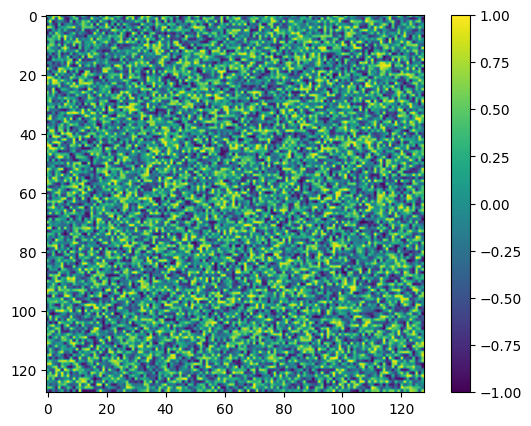

In [6]:
in_field = initialize_field(NX, NY, NZ, mode="random", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [7]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field)

2.93 ms ± 42.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.93 ms ± 42.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [8]:
result_gt4py_numpy_pointwise = _
save_result(result_gt4py_numpy_pointwise, "gt4py_numpy_pointwise")

In [9]:
time_list_pointwise = read_results("list_pointwise")
time_array_pointwise = read_results("array_pointwise")
time_numpy_pointwise = read_results("numpy_pointwise")
time_numba_pointwise = read_results("numba_pointwise")
time_numba_parallel_pointwise = read_results("numba_parallel_pointwise")

gt_np_vs_lists = compare_results(result_gt4py_numpy_pointwise.average, time_list_pointwise, "faster")
gt_np_vs_arrays = compare_results(result_gt4py_numpy_pointwise.average, time_array_pointwise, "faster")
gt_np_vs_numpy = compare_results(time_numpy_pointwise, result_gt4py_numpy_pointwise.average, "faster")
gt_np_vs_numba = compare_results(result_gt4py_numpy_pointwise.average, time_numba_pointwise, "faster")
gt_np_vs_numba_parallel = compare_results(result_gt4py_numpy_pointwise.average, time_numba_parallel_pointwise, "faster-%")

md(f"""
We can see that by running with `backend="numpy"`, GT4Py is **{gt_np_vs_lists} times faster than pure python 
code (lists)** and **{gt_np_vs_arrays} times faster than NumPy arrays with `for` loops**. This is super fast,
also **{gt_np_vs_numba} times faster than simple Numba and {gt_np_vs_numba_parallel} faster than Numba using 
multiple threads**! However, numpy is still {gt_np_vs_numpy} times faster than GT4Py, the reason of which is 
explored in the appendix of [the past list and Numpy notebook](./1_lists_numpy.ipynb). An extra explanation 
is that simply copying an array is a way too easy task, and the stencil compiling by GT4Py takes a much 
longer time.
""")


We can see that by running with `backend="numpy"`, GT4Py is **~2808 times faster than pure python 
code (lists)** and **~5124 times faster than NumPy arrays with `for` loops**. This is super fast,
also **~11 times faster than simple Numba and ~14% faster than Numba using 
multiple threads**! However, numpy is still ~82 times faster than GT4Py, the reason of which is 
explored in the appendix of [the past list and Numpy notebook](./1_lists_numpy.ipynb). An extra explanation 
is that simply copying an array is a way too easy task, and the stencil compiling by GT4Py takes a much 
longer time.


Now let's try the sine computation. GT4Py supports a sine calculation with a simple `sin()` function inside a stencil, which works similar to `np.sin`:

In [10]:
def gt4py_sin_pointwise_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    with computation(PARALLEL), interval(...):
        out_field[0, 0, 0] = sin(in_field[0, 0, 0])

def gt4py_sin_pointwise(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    domain = (
        in_field.shape[0],
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        
        gt4py_sin_pointwise_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
            
    return out_field

In [11]:
backend = "numpy"
gt4py_sin_pointwise_stencil = gtscript.stencil(backend=backend, definition=gt4py_sin_pointwise_def)

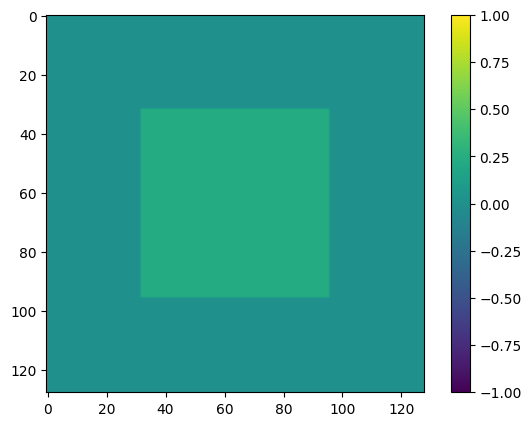

In [12]:
in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_sin_pointwise(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [13]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_sin_pointwise(in_field, out_field)

847 ms ± 8.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 847 ms ± 8.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [14]:
result_gt4py_numpy_sin_pointwise = _
save_result(result_gt4py_numpy_sin_pointwise, "gt4py_numpy_sin_pointwise")

In [15]:
time_list_sin_pointwise = read_results("list_sin_pointwise")
time_numpy_sin_pointwise = read_results("numpy_sin_pointwise")

gt4py_vs_list = compare_results(result_gt4py_numpy_sin_pointwise.average, time_list_sin_pointwise, "faster-%")

md(f"""
This result is **{time_list_sin_pointwise}% faster than the Python list computation**, almost the same as the original NumPy 
results ({time_numpy_sin_pointwise * 1e3:.1f}ms). We can say that "numpy" backend here acts exactly as the NumPy code.
""")


This result is **14.3% faster than the Python list computation**, almost the same as the original NumPy 
results (868.0ms). We can say that "numpy" backend here acts exactly as the NumPy code.


### `backend="gt:cpu_ifirst"` and `backend="gt:cpu_kfirst"`

Now let's see how it differs when `backend="gt:cpu_ifirst"` or `backend="gt:cpu_kfirst"`.

In [16]:
backend = "gt:cpu_ifirst"
gt4py_pointwise_stencil = gtscript.stencil(backend=backend, definition=gt4py_pointwise_def)

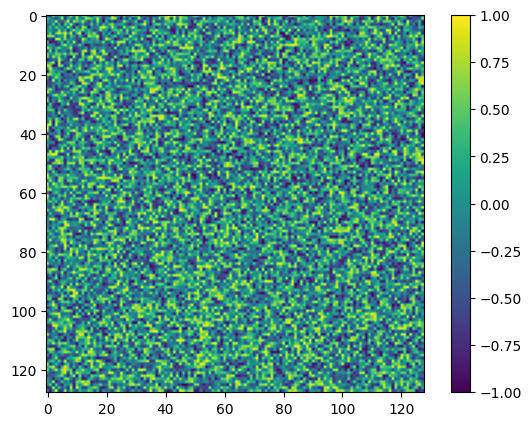

In [17]:
in_field = initialize_field(NX, NY, NZ, mode="random", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [18]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field)

5.15 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 5.15 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [19]:
result_gt4py_ifirst_pointwise = _
save_result(result_gt4py_ifirst_pointwise, "gt4py_ifirst_pointwise")

In [20]:
backend = "gt:cpu_kfirst"
gt4py_pointwise_stencil = gtscript.stencil(backend=backend, definition=gt4py_pointwise_def)

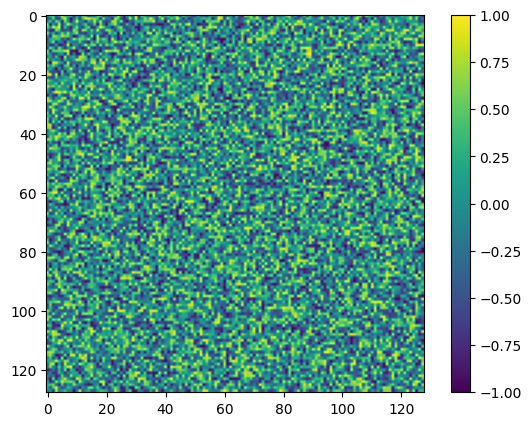

In [21]:
in_field = initialize_field(NX, NY, NZ, mode="random", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [22]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise(in_field, out_field)

5.36 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 5.36 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [23]:
result_gt4py_kfirst_pointwise = _
save_result(result_gt4py_kfirst_pointwise, "gt4py_kfirst_pointwise")

It seems that `numpy` is actually a better backend than `GridTools` in this case. It can be either because the pointwise copy task is simply too easy for multi-core processing and the threading process is time-consuming, or because there's something wrong with how `GridTools` works with CSCS setting here, which is highly unlikely as it is developed exactly for CSCS. We may also expect to see a different performance for an array with larger shapes as GridTools might be more efficient over larger arrays requiring memory allocation.

In the case above we define `origin` (starting index) and `domain` (computation region without halos) manually, like what we've learnt in class. Let's see if the performance changes with the default setting, which is possible in this example as the default setting is just what we need. This greatly simplifies the function and looks much more intuitive.

In [24]:
def gt4py_pointwise_default(in_field, out_field):

    for n in range(N_ITER):
        gt4py_pointwise_stencil(
            in_field=in_field,
            out_field=out_field
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

Here the stencil function is the same as the previous one, so we don't need to compile again.

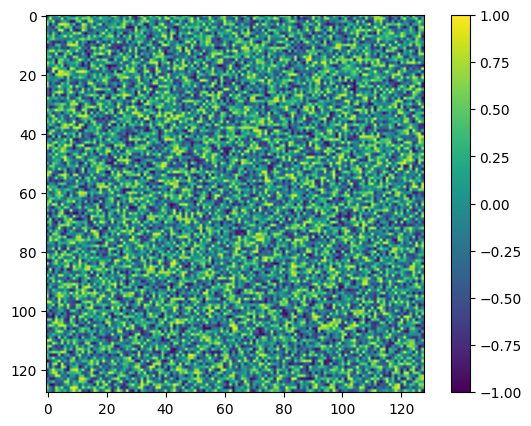

In [25]:
in_field = initialize_field(NX, NY, NZ, mode="random", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise_default(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [26]:
%%timeit in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_pointwise_default(in_field, out_field)

5.45 ms ± 615 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It seems that in this plain case the index and domain information can be omitted, and GT4Py will find it alone, which has almost no impact on the execution time.

In [27]:
md(f"""
| Function                    | Time                                                |
|:----------------------------|----------------------------------------------------:|
| `list_pointwise()`          |  {time_list_pointwise:.1f}s                         |
| `array_pointwise()`         |  {time_array_pointwise:.1f}s                        |
| `numpy_pointwise()`         |  {time_numpy_pointwise * 1e6:.1f}μs                 |
| `numba_pointwise()`         |  {time_numba_pointwise * 1e3:.1f}ms                 |
| `numba_parallel_pointwise()`|  {time_numba_parallel_pointwise * 1e3:.1f}ms        |
| `gt4py_numpy_pointwise()`   |  {result_gt4py_numpy_pointwise.average * 1e3:.1f}ms |
| `gt4py_ifirst_pointwise()`  |  {result_gt4py_ifirst_pointwise.average * 1e3:.1f}ms|
| `gt4py_kfirst_pointwise()`  |  {result_gt4py_kfirst_pointwise.average * 1e3:.1f}ms|
""")


| Function                    | Time                                                |
|:----------------------------|----------------------------------------------------:|
| `list_pointwise()`          |  8.2s                         |
| `array_pointwise()`         |  15.0s                        |
| `numpy_pointwise()`         |  35.7μs                 |
| `numba_pointwise()`         |  31.9ms                 |
| `numba_parallel_pointwise()`|  3.3ms        |
| `gt4py_numpy_pointwise()`   |  2.9ms |
| `gt4py_ifirst_pointwise()`  |  5.1ms|
| `gt4py_kfirst_pointwise()`  |  5.4ms|


Now let's turn to sine calculation:

In [28]:
backend = "gt:cpu_ifirst"
gt4py_sin_pointwise_stencil = gtscript.stencil(backend=backend, definition=gt4py_sin_pointwise_def)

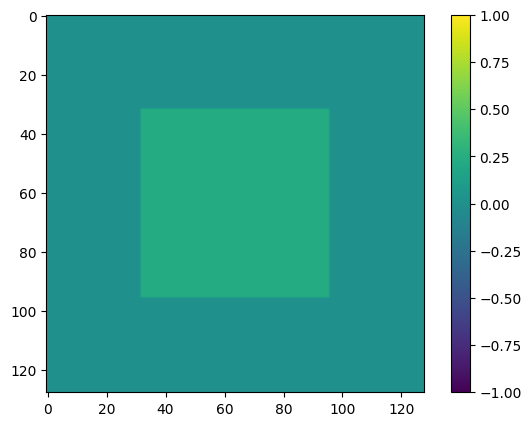

In [29]:
in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_sin_pointwise(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [30]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_sin_pointwise(in_field, out_field)

57.9 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 57.9 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [31]:
result_gt4py_ifirst_sin_pointwise = _
save_result(result_gt4py_ifirst_sin_pointwise, "gt4py_ifirst_sin_pointwise")

In [32]:
backend = "gt:cpu_kfirst"
gt4py_sin_pointwise_stencil = gtscript.stencil(backend=backend, definition=gt4py_sin_pointwise_def)

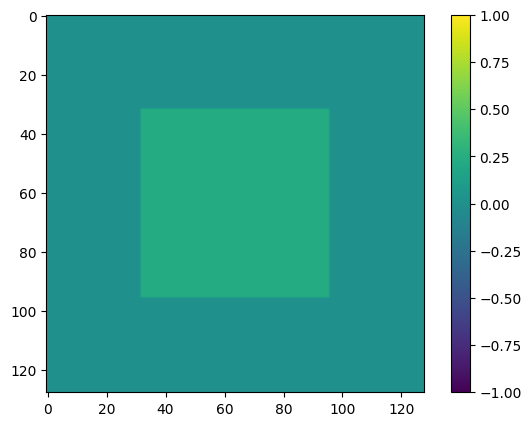

In [33]:
in_field = initialize_field(NX, NY, NZ, mode="square", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_sin_pointwise(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [34]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_sin_pointwise(in_field, out_field)

57.9 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 57.9 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [35]:
result_gt4py_kfirst_sin_pointwise = _
save_result(result_gt4py_kfirst_sin_pointwise, "gt4py_kfirst_sin_pointwise")

In [36]:
time_numba_parallel_sin_pointwise = read_results("numba_parallel_sin_pointwise")
gt4py_ifirst_vs_list = compare_results(result_gt4py_ifirst_sin_pointwise.average, time_list_sin_pointwise, "faster")

md(f"""
ifirst and kfirst backend performs similarly in sine calculation tasks. With them GT4Py is now **{gt4py_ifirst_vs_list} times 
faster than the Python list code**, similar to Numba code ({time_numba_parallel_sin_pointwise * 1e3:.1f}ms). It must have 
benefited a lot from the parallel acceleration.
""")


ifirst and kfirst backend performs similarly in sine calculation tasks. With them GT4Py is now **~247 times 
faster than the Python list code**, similar to Numba code (61.6ms). It must have 
benefited a lot from the parallel acceleration.


In [37]:
md(f"""
| Function                           |  Time                                                        |
|:-----------------------------------|-------------------------------------------------------------:|
| `numpy_sin_pointwise()`            |  {time_numpy_sin_pointwise * 1e3:.0f}ms                      |
| `numba_parallel_sin_pointwise()`   |  {time_numba_parallel_sin_pointwise * 1e3:.1f}ms             |
| `gt4py_numpy_sin_pointwise()`      |  {result_gt4py_numpy_sin_pointwise.average * 1e3:.1f}ms      |
| `gt4py_ifirst_sin_pointwise()`     |  {result_gt4py_ifirst_sin_pointwise.average * 1e3:.1f}ms     |
| `gt4py_kfirst_sin_pointwise()`     |  {result_gt4py_kfirst_sin_pointwise.average * 1e3:.1f}ms     |
""")


| Function                           |  Time                                                        |
|:-----------------------------------|-------------------------------------------------------------:|
| `numpy_sin_pointwise()`            |  868ms                      |
| `numba_parallel_sin_pointwise()`   |  61.6ms             |
| `gt4py_numpy_sin_pointwise()`      |  847.2ms      |
| `gt4py_ifirst_sin_pointwise()`     |  57.9ms     |
| `gt4py_kfirst_sin_pointwise()`     |  57.9ms     |


## 1D Stencils

Now we apply GT4Py to 1D stencil calculation. First we go along columnwise direction.

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

#### `backend="numpy"`

In [38]:
def gt4py_1D_same_col_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):
    
    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[1, 0, 0] - in_field[0, 0, 0])

def gt4py_1D_same_col(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    nx = in_field.shape[0] - 1
    domain = (
        nx,
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        # Update halo value
        in_field[nx, :, :] = in_field[0, :, :]
        
        gt4py_1D_same_col_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

In [39]:
backend = "numpy"
gt4py_1D_same_col_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_col_def)

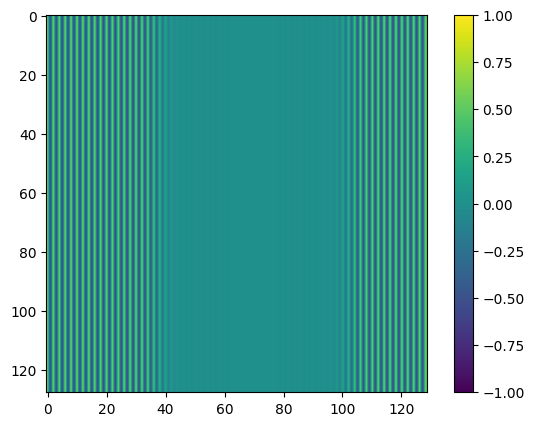

In [40]:
in_field = initialize_field(NX+1, NY, NZ, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [41]:
%%timeit -o in_field = initialize_field(NX+1, NY, NZ, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)

118 ms ± 729 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 118 ms ± 729 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [42]:
result_gt4py_numpy_1D_same_col = _
save_result(result_gt4py_numpy_1D_same_col, "gt4py_numpy_1D_same_col")

In [43]:
time_list_1D_same_col = read_results("list_1D_same_col_ZYX")
time_numpy_1D_same_col = read_results("numpy_1D_same_col")
time_numba_1D_same_col = read_results("numba_1D_same_col")

gt_np_vs_lists = compare_results(result_gt4py_numpy_1D_same_col.average, time_list_1D_same_col, "faster")

md(f"""
By running with `backend="numpy"`, GT4Py is **{gt_np_vs_lists} times faster than pure python 
code (lists)**, and performs similarly with NumPy ({time_numpy_1D_same_col * 1e3:.1f}ms).
""")


By running with `backend="numpy"`, GT4Py is **~126 times faster than pure python 
code (lists)**, and performs similarly with NumPy (117.0ms).


Then we change the memory order of the array (here it's actually `gt.storage` class) to Fortran style to see if the duration changes.

In [44]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, array_order="F", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)

118 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The Fortran-style memory layout seems to have almost no impact on the running time. This is a bit surprising as it's the correct layout for a columnwise computation for GT4Py's `[i,j,k]` dimension sequence. But the gap is so small between C-style and F-style layout, which makes people easily wonder if GT4Py just manages them in the same way. The following blocks test this guess:

In [45]:
field_1 = initialize_field(NX, NY, NZ, mode="horizontal-bars", array_order="C")
field_2 = initialize_field(NX, NY, NZ, mode="horizontal-bars", array_order="F")
# Check numpy memory layout
print(f'field_1 is C-style: {field_1.flags["C_CONTIGUOUS"]}')
print(f'field_2 is C-style: {field_2.flags["C_CONTIGUOUS"]}')

field_1 is C-style: True
field_2 is C-style: False


Then we transform both fields into `gt.storage` type with `"numpy"` backend and check again the layout:

In [46]:
backend = "numpy"
field_1_gt_storage = gt.storage.from_array(field_1, backend=backend, aligned_index=(0, 0, 0))
field_2_gt_storage = gt.storage.from_array(field_2, backend=backend, aligned_index=(0, 0, 0))
print(f'field_1_gt_storage is C-style: {field_1_gt_storage.flags["C_CONTIGUOUS"]}')
print(f'field_2_gt_storage is C-style: {field_2_gt_storage.flags["C_CONTIGUOUS"]}')

field_1_gt_storage is C-style: True
field_2_gt_storage is C-style: True


Yes. As mentioned before GT4Py translates python code into C++ code to reach higher performance. This is probably why here `gt.storage.from_array` function automatically transforms both arrays into C-style layout, and they perform at similar speed.

#### `backend="gt:cpu_ifirst"` and `backend="gt:cpu_kfirst"`

Now again let's check if `backend="gt:cpu_ifirst"` and `backend="gt:cpu_kfirst"` perform differently from `backend="numpy"`.

In [47]:
backend = "gt:cpu_ifirst"
gt4py_1D_same_col_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_col_def)

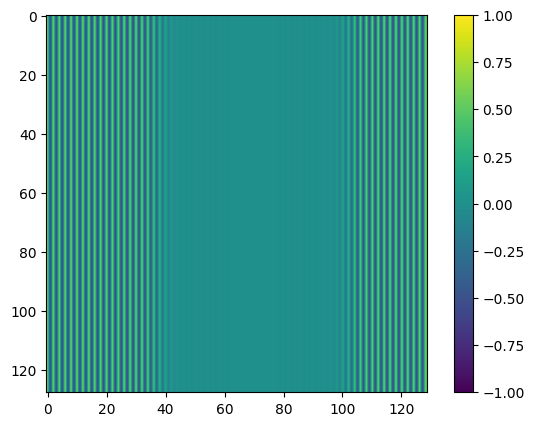

In [48]:
in_field = initialize_field(NX+1, NY, NZ, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [49]:
%%timeit -o in_field = initialize_field(NX+1, NY, NZ, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)

11.1 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 11.1 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [50]:
result_gt4py_ifirst_1D_same_col = _
save_result(result_gt4py_ifirst_1D_same_col, "gt4py_ifirst_1D_same_col")

In [51]:
backend = "gt:cpu_kfirst"
gt4py_1D_same_col_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_col_def)

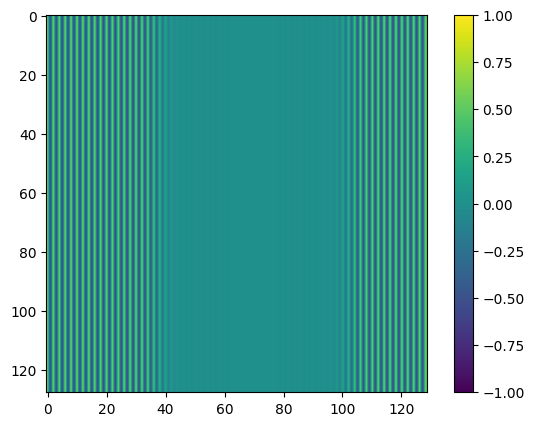

In [52]:
in_field = initialize_field(NX+1, NY, NZ, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [53]:
%%timeit -o in_field = initialize_field(NX+1, NY, NZ, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)

7.54 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 7.54 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [54]:
result_gt4py_kfirst_1D_same_col = _
save_result(result_gt4py_kfirst_1D_same_col, "gt4py_kfirst_1D_same_col")

In [55]:
gt_kfirst_vs_numpy = compare_results(result_gt4py_kfirst_1D_same_col.average, time_numpy_1D_same_col, "faster")

md(f"""
Yes! GridTools optimization is at most **{gt_kfirst_vs_numpy} times faster than numpy** this time with 
`backend=gt:cpu_kfirst`, as the parallel computation greatly speeds up the code, but it's still 
slower than Numba ({time_numba_1D_same_col * 1e3:.1f}ms). It's worth noticing that `gt:cpu_kfirst` 
is considerably faster than `"gt:cpu_ifirst"`.
""")


Yes! GridTools optimization is at most **~16 times faster than numpy** this time with 
`backend=gt:cpu_kfirst`, as the parallel computation greatly speeds up the code, but it's still 
slower than Numba (3.7ms). It's worth noticing that `gt:cpu_kfirst` 
is considerably faster than `"gt:cpu_ifirst"`.


According to the GT4Py document:

>`gt:cpu_kfirst`: a backend based on GridTools code performance-optimized for x86 architecture\
`gt:cpu_ifirst`: a GridTools backend targeting many core architectures

This doesn't explain their differences well. So we need to look into the GridTools document used by GT4Py:

>`cpu_kfirst`: Layout is chosen to benefit from data locality while doing 3D loop. `malloc` allocation. No 
alignment. (...)\
>`cpu_ifirst`: Huge page allocation. 8 bytes alignment. Layout is tailored to utilize vectorization while 
3D looping. (...)

This is still not so clear why they perform differently. Let's return to it's literal meaning: `ifirst` means 
"i in first order", allocating memory in C-style, and `kfirst` means "k in first order", which is 
Fortran-style. As mentioned in the [lists and NumPy notebook](./1_lists_numpy.ipynb), we can quickly test if 
`NZ=128` merges the gap as the strides are now similar.

In [56]:
backend = "gt:cpu_ifirst"
gt4py_1D_same_col_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_col_def)

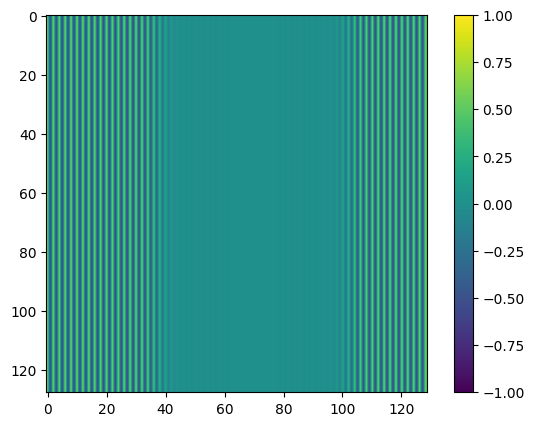

In [57]:
in_field = initialize_field(NX+1, NY, 128, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [58]:
%%timeit in_field = initialize_field(NX+1, NY, 128, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)

16.4 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
backend = "gt:cpu_kfirst"
gt4py_1D_same_col_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_col_def)

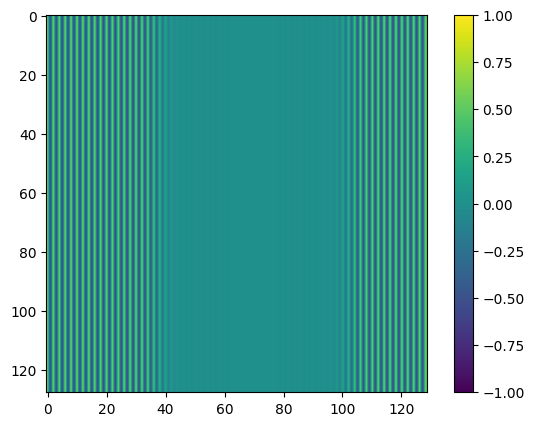

In [60]:
in_field = initialize_field(NX+1, NY, 128, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)
plot_field(out_field, dim_order="XYZ")

In [61]:
%%timeit in_field = initialize_field(NX+1, NY, 128, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_col(in_field, out_field)

11.3 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Again there are still differences. We can infer that this is also due to the different ways that `gt:cpu_ifirst` and `gt:cpu_kfirst` iterate through the array. We can also test that in the way similar to the [lists and NumPy notebook](./1_lists_numpy.ipynb):

In [62]:
def gt4py_1D_index_1_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):
    
    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[1, 0, 0] - in_field[0, 0, 0])

def gt4py_1D_index_1(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    nx = in_field.shape[0] - 1
    domain = (
        nx,
        in_field.shape[1],
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        # Update halo value
        in_field[nx, :, :] = in_field[0, :, :]
        
        gt4py_1D_index_1_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

def gt4py_1D_index_2_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):
    
    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[0, 1, 0] - in_field[0, 0, 0])

def gt4py_1D_index_2(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    ny = in_field.shape[1] - 1
    domain = (
        in_field.shape[0],
        ny,
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        # Update halo value
        in_field[:, ny, :] = in_field[:, 0, :]
        
        gt4py_1D_index_2_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

def gt4py_1D_index_3_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):
    
    # Here the PARALLEL computation might actually create weird results. BACKWARD should be the right solution.
    # But we just ignore here
    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[0, 0, 1] - in_field[0, 0, 0])

def gt4py_1D_index_3(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    nz = in_field.shape[2] - 1
    domain = (
        in_field.shape[0],
        in_field.shape[1],
        nz
    )
    # Iteration
    for n in range(N_ITER):
        # Update halo value
        in_field[:, :, nz] = in_field[:, :, 0]
        
        gt4py_1D_index_3_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

In [63]:
backend = "gt:cpu_ifirst"
gt4py_1D_index_1_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_index_1_def)
gt4py_1D_index_2_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_index_2_def)
gt4py_1D_index_3_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_index_3_def)

In [64]:
in_field = initialize_field(129, 128, 128, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_1(in_field, out_field)

In [65]:
%%timeit in_field = initialize_field(129, 128, 128, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_1(in_field, out_field)

16.4 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
in_field = initialize_field(128, 129, 128, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_2(in_field, out_field)

In [67]:
%%timeit in_field = initialize_field(128, 129, 128, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_2(in_field, out_field)

11.4 ms ± 513 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
in_field = initialize_field(128, 128, 129, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_3(in_field, out_field)

In [69]:
%%timeit in_field = initialize_field(128, 128, 129, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_3(in_field, out_field)

10.3 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
backend = "gt:cpu_kfirst"
gt4py_1D_index_1_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_index_1_def)
gt4py_1D_index_2_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_index_2_def)
gt4py_1D_index_3_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_index_3_def)

In [71]:
in_field = initialize_field(129, 128, 128, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_1(in_field, out_field)

In [72]:
%%timeit in_field = initialize_field(129, 128, 128, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_1(in_field, out_field)

11.4 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
in_field = initialize_field(128, 129, 128, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_2(in_field, out_field)

In [74]:
%%timeit in_field = initialize_field(128, 129, 128, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_2(in_field, out_field)

11.8 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
in_field = initialize_field(128, 128, 129, mode="vertical-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_3(in_field, out_field)

In [76]:
%%timeit in_field = initialize_field(128, 128, 129, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_index_3(in_field, out_field)

16.1 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The results resemble that in the [lists and NumPy notebook](./1_lists_numpy.ipynb), where `gt:cpu_kfirst` is better at first index iteration, while `gt:cpu_ifirst` is better at last index iteration, and they perform similarly at middle index iteration. Remember here that `i` and `k` are transposed in `gt.storage` structure.

In [77]:
md(f"""
| Function                      | Time                                                  |
|:------------------------------|------------------------------------------------------:|
| `list_1D_same_col()`          |  {time_list_1D_same_col:.1f}s                         |
| `numpy_1D_same_col()`         |  {time_numpy_1D_same_col * 1e3:.0f}ms                 |
| `numba_1D_same_col()`         |  {time_numba_1D_same_col * 1e3:.1f}ms                 |
| `gt4py_numpy_1D_same_col()`   |  {result_gt4py_numpy_1D_same_col.average * 1e3:.1f}ms |
| `gt4py_ifirst_1D_same_col()`  |  {result_gt4py_ifirst_1D_same_col.average * 1e3:.1f}ms|
| `gt4py_kfirst_1D_same_col()`  |  {result_gt4py_kfirst_1D_same_col.average * 1e3:.1f}ms|
""")


| Function                      | Time                                                  |
|:------------------------------|------------------------------------------------------:|
| `list_1D_same_col()`          |  14.9s                         |
| `numpy_1D_same_col()`         |  117ms                 |
| `numba_1D_same_col()`         |  3.7ms                 |
| `gt4py_numpy_1D_same_col()`   |  117.9ms |
| `gt4py_ifirst_1D_same_col()`  |  11.1ms|
| `gt4py_kfirst_1D_same_col()`  |  7.5ms|


Now let's check its performance with rowwise setup:

###  Same row: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

From previous work we've already known that whether `array_order="C"` or `array_order="F"` in `initialize_field` has almost no impact on the running time. Also, as the second index that is going to be computed, the performance should be similar for `backend="gt:cpu_ifirst"` and `backend="gt:cpu_kfirst"`.

#### `backend="numpy"`

In [78]:
def gt4py_1D_same_row_def(
    in_field: gtscript.Field[np.float64],
    out_field: gtscript.Field[np.float64],
):

    with computation(PARALLEL), interval(...):
        # Apply 1D stencil in gt4py style
        out_field = 0.5 * (in_field[0, 1, 0] - in_field[0, 0, 0])

def gt4py_1D_same_row(in_field, out_field):
    # Define origin and domain for the stencil
    origin = (0, 0, 0)
    ny = in_field.shape[1] - 1
    domain = (
        in_field.shape[0],
        ny,
        in_field.shape[2]
    )
    # Iteration
    for n in range(N_ITER):
        # Update halo value
        in_field[:, ny, :] = in_field[:, 0, :]
        
        gt4py_1D_same_row_stencil(
            in_field=in_field,
            out_field=out_field,
            origin=origin,
            domain=domain
        )
        
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

In [79]:
backend = "numpy"
gt4py_1D_same_row_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_row_def)

In [80]:
in_field = initialize_field(NX, NY+1, NZ, mode="horizontal-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)

In [81]:
%%timeit -o in_field = initialize_field(NX+1, NY, NZ, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)

108 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 108 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [82]:
result_gt4py_numpy_1D_same_row = _
save_result(result_gt4py_numpy_1D_same_row, "gt4py_numpy_1D_same_row")

In [83]:
%%timeit in_field = initialize_field(NX+1, NY, NZ, array_order="F", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)

108 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The results of different `array_order` proves the assumption again.

#### `backend="gt:cpu_ifirst"` and `backend="gt:cpu_kfirst"`

In [84]:
backend = "gt:cpu_ifirst"
gt4py_1D_same_row_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_row_def)

In [85]:
in_field = initialize_field(NX, NY+1, NZ, mode="horizontal-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)

In [86]:
%%timeit -o in_field = initialize_field(NX+1, NY, NZ, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)

7.5 ms ± 478 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 7.5 ms ± 478 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [87]:
result_gt4py_ifirst_1D_same_row = _
save_result(result_gt4py_ifirst_1D_same_row, "gt4py_ifirst_1D_same_row")

In [88]:
backend = "gt:cpu_kfirst"
gt4py_1D_same_row_stencil = gtscript.stencil(backend=backend, definition=gt4py_1D_same_row_def)

In [89]:
in_field = initialize_field(NX, NY+1, NZ, mode="horizontal-bars", array_order="C", dim_order="XYZ")
out_field = np.zeros_like(in_field)
in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)

In [90]:
%%timeit -o in_field = initialize_field(NX+1, NY, NZ, array_order="C", dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(0, 0, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(0, 0, 0))
out_field = gt4py_1D_same_row(in_field, out_field)

8.6 ms ± 384 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 8.6 ms ± 384 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [91]:
result_gt4py_kfirst_1D_same_row = _
save_result(result_gt4py_kfirst_1D_same_row, "gt4py_kfirst_1D_same_row")

Now the gap almost merges just as expected.

## 2D stencils
Just like what we've done with Numba, we compare GT4Py performance on 2D stencils with numpy. This time we can directly import functions from the class. As the GT4Py version here is 1.0.1, changes have been made to adjust to current needs.

In [92]:
from stencil2d_gt4py import diffusion_defs, copy_defs

from stencil2d_gt4py import laplacian as laplacian_gt4py
from stencil2d_gt4py import update_halo as update_halo_gt4py
from stencil2d_gt4py import apply_diffusion as apply_diffusion_gt4py

In [93]:
from stencil2d import laplacian, update_halo, apply_diffusion

### `backend="numpy"`

First we see how the GT4Py Laplacian operation performs compared to vectorized numpy.

In [94]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2); out_field = np.zeros_like(in_field)
laplacian(in_field, out_field, num_halo=2)

6.95 ms ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [95]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(2, 2, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(2, 2, 0))
out_field = laplacian_gt4py(in_field)

845 ns ± 20.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


And it's much faster by **over 8000 times**. The stencil-specific optimization of GT4Py is very powerful.\
Next we inspect the halo update function. Here copy function specified for GT4Py stencils are required, so we compile it as well as the diffusion function from the definition function.

In [96]:
backend = "numpy"
dtype = np.float64
copy_stencil = gtscript.stencil(
    backend=backend,
    definition=copy_defs, 
    dtypes={"dtype": dtype}
)

diffusion_stencil = gtscript.stencil(
    backend=backend, 
    definition=diffusion_defs,
    dtypes={"dtype": dtype},
    externals={"laplacian": laplacian_gt4py}
)

True

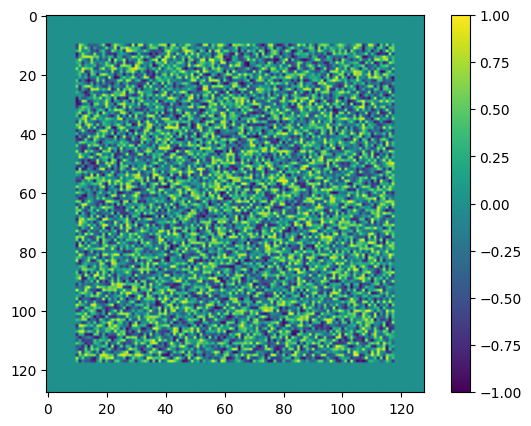

In [97]:
field = initialize_field(NX, NY, NZ, num_halo=10, dim_order="XYZ")
field = gt.storage.from_array(field, backend=backend, aligned_index=(10, 10, 0))
copy_field = gt.storage.from_array(field, backend=backend, aligned_index=(10, 10, 0))
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

False

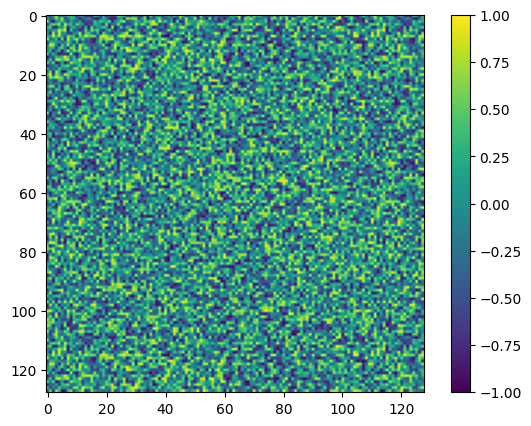

In [98]:
field = np.swapaxes(field, 0, 2)
update_halo(field, num_halo=10)
field = np.swapaxes(field, 0, 2)
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

True

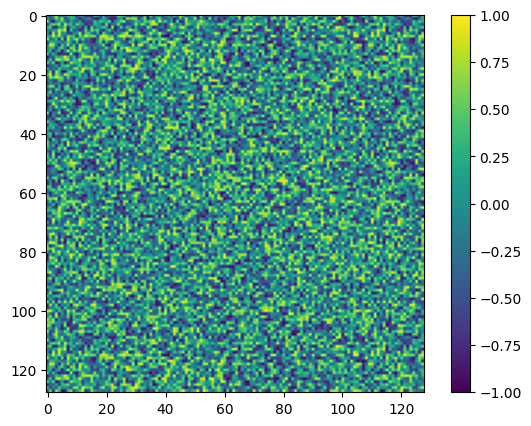

In [99]:
update_halo_gt4py(copy_stencil, copy_field, num_halo=10)
plot_field(copy_field,dim_order="XYZ")
np.array_equal(field, copy_field)

In [100]:
%%timeit field = initialize_field(NX, NY, NZ); copy_field = field.copy()
update_halo(field, num_halo=2)

630 µs ± 5.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [101]:
%%timeit field = initialize_field(NX, NY, NZ, dim_order="XYZ"); field = gt.storage.from_array(field, backend=backend, aligned_index=(0, 0, 0)); copy_field = gt.storage.from_array(field, backend=backend, aligned_index=(0, 0, 0))
update_halo_gt4py(copy_stencil, field, num_halo=2)

322 µs ± 887 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Again, GT4Py is faster than vectorized NumPy code for the halo update. Other than reading in the whole array indices of both `in_field` and `out_field` like NumPy does, GT4Py updates the halo only by reading the origin point index of the single stencil. This alleviates the memory-reading bottleneck and mostly explains its performance boost.

Now we test the 2D stencil function `apply_diffusion()` and see difference in their performances.

In [102]:
in_field = initialize_field(NX, NY, NZ, mode="square", num_halo=0)
in_field2 = initialize_field(NX, NY, NZ, dim_order="XYZ", mode="square", num_halo=0)
out_field2 = np.zeros_like(in_field2)
in_field2 = gt.storage.from_array(in_field2, backend=backend, aligned_index=(2, 2, 0))
out_field2 = gt.storage.from_array(out_field2, backend=backend, aligned_index=(2, 2, 0))

alpha = 1.0 / 32.0

out_field = apply_diffusion(in_field, num_halo=2, num_iter=N_ITER)
out_field2 = apply_diffusion_gt4py(
    diffusion_stencil,
    copy_stencil, 
    in_field2,
    out_field2,
    alpha=alpha,
    num_halo=2,
    num_iter=N_ITER
)

out_field2 = np.swapaxes(out_field2, 0, 2)

np.allclose(out_field, out_field2, rtol=1e-5, atol=1e-8, equal_nan=True)

True

In [103]:
%%timeit in_field = initialize_field(NX, NY, NZ)
out_field = apply_diffusion(in_field, num_halo=2, num_iter=N_ITER)

1.06 s ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(2, 2, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(2, 2, 0))
out_field = apply_diffusion_gt4py(diffusion_stencil, copy_stencil, in_field, out_field, alpha=alpha, num_halo=2, num_iter=N_ITER)

4.45 s ± 8.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 4.45 s ± 8.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [105]:
result_gt4py_numpy_2D = _
save_result(result_gt4py_numpy_2D, "gt4py_numpy_2D")

**GT4Py numpy backend is much slower than plain numpy!** Since the halo update part of the function has already been tested, the bottleneck has to be the diffusion module. Let's test if it's the case.

In [106]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2); out_field = np.zeros_like(in_field); tmp_field = np.zeros_like(in_field); alpha = 1.0 / 32.0; num_halo = 2; num_iter=N_ITER
laplacian(in_field, tmp_field, num_halo=num_halo, extend=1)
laplacian(tmp_field, out_field, num_halo=num_halo, extend=0)

out_field[:, num_halo:-num_halo, num_halo:-num_halo] = (
    in_field[:, num_halo:-num_halo, num_halo:-num_halo]
    - alpha * out_field[:, num_halo:-num_halo, num_halo:-num_halo]
)

21.3 ms ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(2, 2, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(2, 2, 0)); origin = (2,2,0); domain = (NX-4, NY-4, NZ); alpha = 1.0/32.0
diffusion_stencil(
    in_field=in_field,
    out_field=out_field,
    alpha=alpha,
    origin=origin,
    domain=domain,
)

89.1 ms ± 463 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Yes it is! The diffusion stencil in GT4Py is much slower than the numpy solution. This should have something to do with the fact that the way GT4Py adapts the origin index doesn't suit well with the diffusion equation. The origin index is set at (2,2,0), which in theory should accelerate laplacian. However, with diffusion we have to access the halo part frequently, and at numpy backend it is unfriendly to GT4Py memory reading and can cause a slowdown.

### `backend="gt:cpu_ifirst"` and `backend="gt:cpu_kfirst"`

Now let's try `backend="gt:cpu_ifirst"` and `backend="gt:cpu_kfirst"` respectively:

In [108]:
backend = "gt:cpu_ifirst"
dtype = np.float64
copy_stencil = gtscript.stencil(
    backend=backend,
    definition=copy_defs, 
    dtypes={"dtype": dtype}
)

diffusion_stencil = gtscript.stencil(
    backend=backend, 
    definition=diffusion_defs,
    dtypes={"dtype": dtype},
    externals={"laplacian": laplacian_gt4py}
)

In [109]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(2, 2, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(2, 2, 0))
out_field = laplacian_gt4py(in_field)

825 ns ± 8.15 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


True

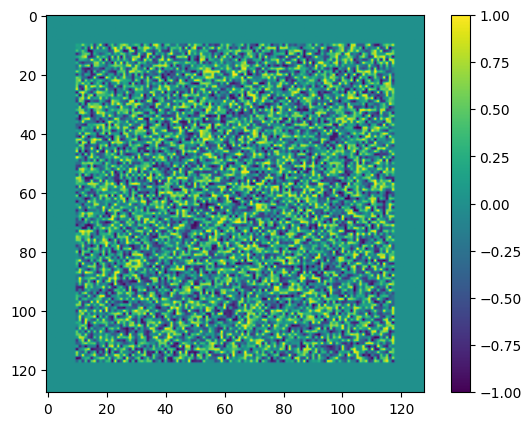

In [110]:
field = initialize_field(NX, NY, NZ, num_halo=10, dim_order="XYZ")
field = gt.storage.from_array(field, backend=backend, aligned_index=(10, 10, 0))
copy_field = gt.storage.from_array(field, backend=backend, aligned_index=(10, 10, 0))
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

False

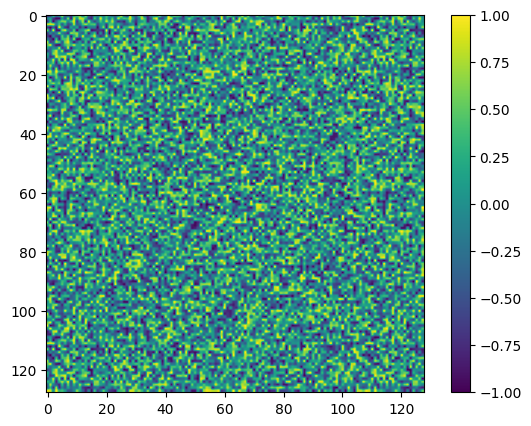

In [111]:
field = np.swapaxes(field, 0, 2)
update_halo(field, num_halo=10)
field = np.swapaxes(field, 0, 2)
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

True

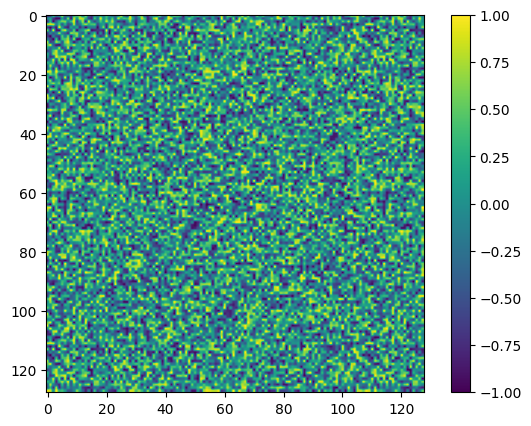

In [112]:
update_halo_gt4py(copy_stencil, copy_field, num_halo=10)
plot_field(copy_field,dim_order="XYZ")
np.array_equal(field, copy_field)

In [113]:
%%timeit field = initialize_field(NX, NY, NZ, dim_order="XYZ"); field = gt.storage.from_array(field, backend=backend, aligned_index=(0, 0, 0)); copy_field = gt.storage.from_array(field, backend=backend, aligned_index=(0, 0, 0))
update_halo_gt4py(copy_stencil, field, num_halo=2)

143 µs ± 5.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [114]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(2, 2, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(2, 2, 0)); origin = (2, 2, 0); domain = (NX-4, NY-4, NZ); alpha = 1.0/32.0
diffusion_stencil(
    in_field=in_field,
    out_field=out_field,
    alpha=alpha,
    origin=origin,
    domain=domain,
)

527 µs ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [115]:
in_field = initialize_field(NX, NY, NZ, mode="square", num_halo=0)
in_field2 = initialize_field(NX, NY, NZ, dim_order="XYZ", mode="square", num_halo=0)
out_field2 = np.zeros_like(in_field2)
in_field2 = gt.storage.from_array(in_field2, backend=backend, aligned_index=(2, 2, 0))
out_field2 = gt.storage.from_array(out_field2, backend=backend, aligned_index=(2, 2, 0))

alpha = 1.0 / 32.0

out_field = apply_diffusion(in_field, num_halo=2, num_iter=N_ITER)
out_field2 = apply_diffusion_gt4py(
    diffusion_stencil,
    copy_stencil,
    in_field2,
    out_field2,
    alpha=alpha,
    num_halo=2, 
    num_iter=N_ITER
)

out_field2 = np.swapaxes(out_field2, 0, 2)

np.allclose(out_field, out_field2, rtol=1e-5, atol=1e-8, equal_nan=True)

True

In [116]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(2, 2, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(2, 2, 0))
out_field = apply_diffusion_gt4py(diffusion_stencil, copy_stencil, in_field, out_field, alpha=alpha, num_halo=2, num_iter=N_ITER)

36.2 ms ± 4.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 36.2 ms ± 4.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [117]:
result_gt4py_ifirst_2D = _
save_result(result_gt4py_ifirst_2D, "gt4py_ifirst_2D")

In [118]:
time_numpy_2D = read_results("numpy_2D")
time_numba_2D = read_results("numba_2D")

ifirst_vs_numpy_2D = compare_results(result_gt4py_ifirst_2D.average, result_gt4py_numpy_2D.average, "faster")
ifirst_vs_np_2D = compare_results(result_gt4py_ifirst_2D.average, time_numpy_2D, "faster")

md(f"""
With `backend="gt:cpu_ifirst"` the 2D stencil is **{ifirst_vs_numpy_2D} times faster** than that with 
`backend="numpy"`, and **{ifirst_vs_np_2D} times faster** than plain NumPy. This is quite impressive, and most 
optimization takes place in the diffusion procedure, reducing the running time from ~20 ms to ~600 μs. However, 
it's still noticing that it is slower than Numba ({time_numba_2D * 1e3:.1f}ms).
""")


With `backend="gt:cpu_ifirst"` the 2D stencil is **~123 times faster** than that with 
`backend="numpy"`, and **~30 times faster** than plain NumPy. This is quite impressive, and most 
optimization takes place in the diffusion procedure, reducing the running time from ~20 ms to ~600 μs. However, 
it's still noticing that it is slower than Numba (22.3ms).


Then with `backend="gt:cpu_k_first"`:

In [119]:
backend = "gt:cpu_kfirst"
dtype = np.float64
copy_stencil = gtscript.stencil(
    backend=backend,
    definition=copy_defs, 
    dtypes={"dtype": dtype}
)

diffusion_stencil = gtscript.stencil(
    backend=backend, 
    definition=diffusion_defs,
    dtypes={"dtype": dtype},
    externals={"laplacian": laplacian_gt4py}
)

In [120]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(2, 2, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(2, 2, 0))
out_field = laplacian_gt4py(in_field)

834 ns ± 17.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


True

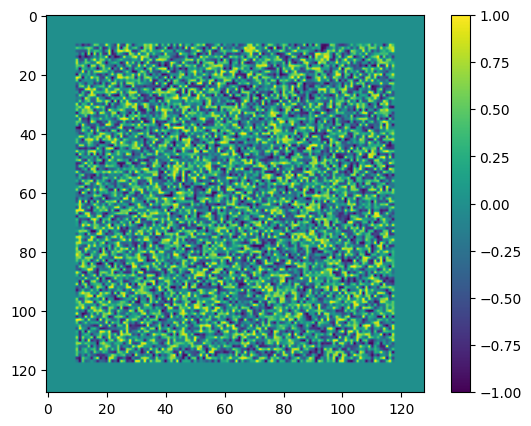

In [121]:
field = initialize_field(NX, NY, NZ, num_halo=10, dim_order="XYZ")
field = gt.storage.from_array(field, backend=backend, aligned_index=(10, 10, 0))
copy_field = gt.storage.from_array(field, backend=backend, aligned_index=(10, 10, 0))
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

False

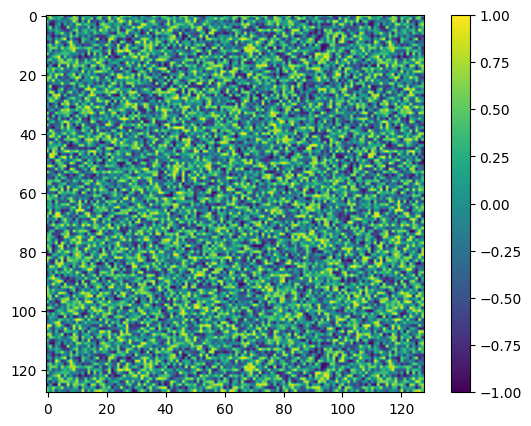

In [122]:
field = np.swapaxes(field, 0, 2)
update_halo(field, num_halo=10)
field = np.swapaxes(field, 0, 2)
plot_field(field, dim_order="XYZ")
np.array_equal(field, copy_field)

True

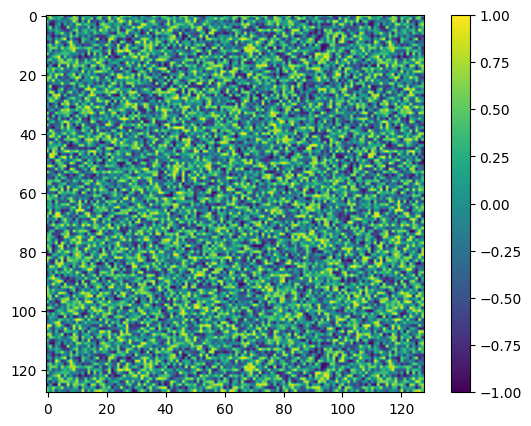

In [123]:
update_halo_gt4py(copy_stencil, copy_field, num_halo=10)
plot_field(copy_field,dim_order="XYZ")
np.array_equal(field, copy_field)

In [124]:
%%timeit field = initialize_field(NX, NY, NZ, dim_order="XYZ"); field = gt.storage.from_array(field, backend=backend, aligned_index=(0, 0, 0)); copy_field = gt.storage.from_array(field, backend=backend, aligned_index=(0, 0, 0))
update_halo_gt4py(copy_stencil, field, num_halo=2)

130 µs ± 3.74 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [125]:
%%timeit in_field = initialize_field(NX, NY, NZ, num_halo=2, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(2, 2, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(2, 2, 0)); origin = (2, 2, 0); domain = (NX-4, NY-4, NZ); alpha = 1.0/32.0
diffusion_stencil(
    in_field=in_field,
    out_field=out_field,
    alpha=alpha,
    origin=origin,
    domain=domain,
)

959 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [126]:
in_field = initialize_field(NX, NY, NZ, mode="square", num_halo=0)
in_field2 = initialize_field(NX, NY, NZ, dim_order="XYZ", mode="square", num_halo=0)
out_field2 = np.zeros_like(in_field2)
in_field2 = gt.storage.from_array(in_field2, backend=backend, aligned_index=(2, 2, 0))
out_field2 = gt.storage.from_array(out_field2, backend=backend, aligned_index=(2, 2, 0))

alpha = 1.0 / 32.0

out_field = apply_diffusion(in_field, num_halo=2, num_iter=N_ITER)
out_field2 = apply_diffusion_gt4py(
    diffusion_stencil, 
    copy_stencil,
    in_field2,
    out_field2,
    alpha=alpha,
    num_halo=2, 
    num_iter=N_ITER
)

out_field2 = np.swapaxes(out_field2, 0, 2)

np.allclose(out_field, out_field2, rtol=1e-5, atol=1e-8, equal_nan=True)

True

In [127]:
%%timeit -o in_field = initialize_field(NX, NY, NZ, dim_order="XYZ"); out_field = np.zeros_like(in_field); in_field = gt.storage.from_array(in_field, backend=backend, aligned_index=(2, 2, 0)); out_field = gt.storage.from_array(out_field, backend=backend, aligned_index=(2, 2, 0))
out_field = apply_diffusion_gt4py(diffusion_stencil, copy_stencil, in_field, out_field, alpha=alpha, num_halo=2, num_iter=N_ITER)

56.3 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 56.3 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [128]:
result_gt4py_kfirst_2D = _
save_result(result_gt4py_kfirst_2D, "gt4py_kfirst_2D")

In [129]:
kfirst_vs_numpy_2D = compare_results(result_gt4py_kfirst_2D.average, result_gt4py_numpy_2D.average, "faster")
kfirst_vs_np_2D = compare_results(result_gt4py_kfirst_2D.average, time_numpy_2D, "faster")

md(f"""
With `backend="gt:cpu_kfirst"` the 2D stencil is **{kfirst_vs_numpy_2D} times faster** than that with `backend="numpy"`, 
and **{kfirst_vs_np_2D} times faster** than plain numpy. This is slower than that with `backend="gt:cpu_ifirst"`, 
and the diffusion procedure only reduces the running time from ~20 ms to ~1 ms.
""")


With `backend="gt:cpu_kfirst"` the 2D stencil is **~79 times faster** than that with `backend="numpy"`, 
and **~20 times faster** than plain numpy. This is slower than that with `backend="gt:cpu_ifirst"`, 
and the diffusion procedure only reduces the running time from ~20 ms to ~1 ms.


In [130]:
md(f"""
| Function               | Time                                           |
|:-----------------------|-----------------------------------------------:|
| `numpy_2D()`           |  {time_numpy_2D:.1f}s                          |
| `numba_2D()`           |  {time_numba_2D * 1e3:.1f}ms                   |
| `gt4py_numpy_2D()`     |  {result_gt4py_numpy_2D.average:.1f}s          |
| `gt4py_ifirst_2D()`    |  {result_gt4py_ifirst_2D.average * 1e3:.1f}ms  |
| `gt4py_kfirst_2D()`    |  {result_gt4py_kfirst_2D.average * 1e3:.1f}ms  |
""")


| Function               | Time                                           |
|:-----------------------|-----------------------------------------------:|
| `numpy_2D()`           |  1.1s                          |
| `numba_2D()`           |  22.3ms                   |
| `gt4py_numpy_2D()`     |  4.5s          |
| `gt4py_ifirst_2D()`    |  36.2ms  |
| `gt4py_kfirst_2D()`    |  56.3ms  |
